In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2
import math
from PIL import Image
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [2]:
WINDOW_SIZE = 10
MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
LABELS_NAME = 'mscoco_label_map.pbtxt'
TEST_IMAGES_DIR_PATH = pathlib.Path('data')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('data/elephant.jpg')]

In [3]:
# Create cache folder.
!mkdir .tmp

mkdir: .tmp: File exists


In [4]:
# Loads the module from internet, unpacks it and initializes a Tensorflow saved model.
def load_model(model_name):
    model_url = 'http://download.tensorflow.org/models/object_detection/' + model_name + '.tar.gz'
    
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    model = tf.saved_model.load(model_dir + '/saved_model')
    
    return model

In [5]:
saved_model = load_model(MODEL_NAME)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-04-18 19:50:07.930562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 19:50:07.930703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-18 19:50:07.956324: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-18 19:50:07.956386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
# Loading default model signature.
model = saved_model.signatures['serving_default']

In [7]:
def load_labels(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").replace('"', "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

In [8]:
labels = load_labels(LABELS_NAME)
labels

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [9]:
def detect_objects_on_image(image, model):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    # Adding one more dimension since model expect a batch of images.
    input_tensor = input_tensor[tf.newaxis, ...]

    output_dict = model(input_tensor)

    num_detections = int(output_dict['num_detections'])
    output_dict = {
        key:value[0, :num_detections].numpy() 
        for key,value in output_dict.items()
        if key != 'num_detections'
    }
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

In [10]:
def draw_detections_on_image(image, detections, labels):
    image_with_detections = image
    width, height, channels = image_with_detections.shape
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    label_padding = 5
    
    num_detections = detections['num_detections']
    if num_detections > 0:
        for detection_index in range(num_detections):
            detection_score = detections['detection_scores'][detection_index]
            detection_box = detections['detection_boxes'][detection_index]
            detection_class = detections['detection_classes'][detection_index]
            detection_label = labels[detection_class]
            detection_label_full = detection_label + ' ' + str(math.floor(100 * detection_score)) + '%'
            
            y1 = int(width * detection_box[0])
            x1 = int(height * detection_box[1])
            y2 = int(width * detection_box[2])
            x2 = int(height * detection_box[3])
                        
            # Detection rectangle.    
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x2, y2),
                color,
                3
            )
            
            # Label background.
            label_size = cv2.getTextSize(
                detection_label_full,
                cv2.FONT_HERSHEY_COMPLEX,
                0.7,
                2
            )
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1 - label_size[0][1] - 2 * label_padding),
                (x1 + label_size[0][0] + 2 * label_padding, y1),
                color,
                -1
            )
            
            # Label text.
            cv2.putText(
                image_with_detections,
                detection_label_full,
                (x1 + label_padding, y1 - label_padding),
                font,
                0.7,
                (0, 0, 0),
                1,
                cv2.LINE_AA
            )
            
    return image_with_detections

In [11]:
# Example of how detections dictionary looks like.
image_np = np.array(Image.open(TEST_IMAGE_PATHS[0]))
detections = detect_objects_on_image(image_np, model)
detections

2024-04-18 19:50:13.846972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


{'detection_classes': array([22]),
 'detection_boxes': array([[0.22753263, 0.11457556, 0.9516684 , 0.8831851 ]], dtype=float32),
 'detection_scores': array([0.99391705], dtype=float32),
 'num_detections': 1}

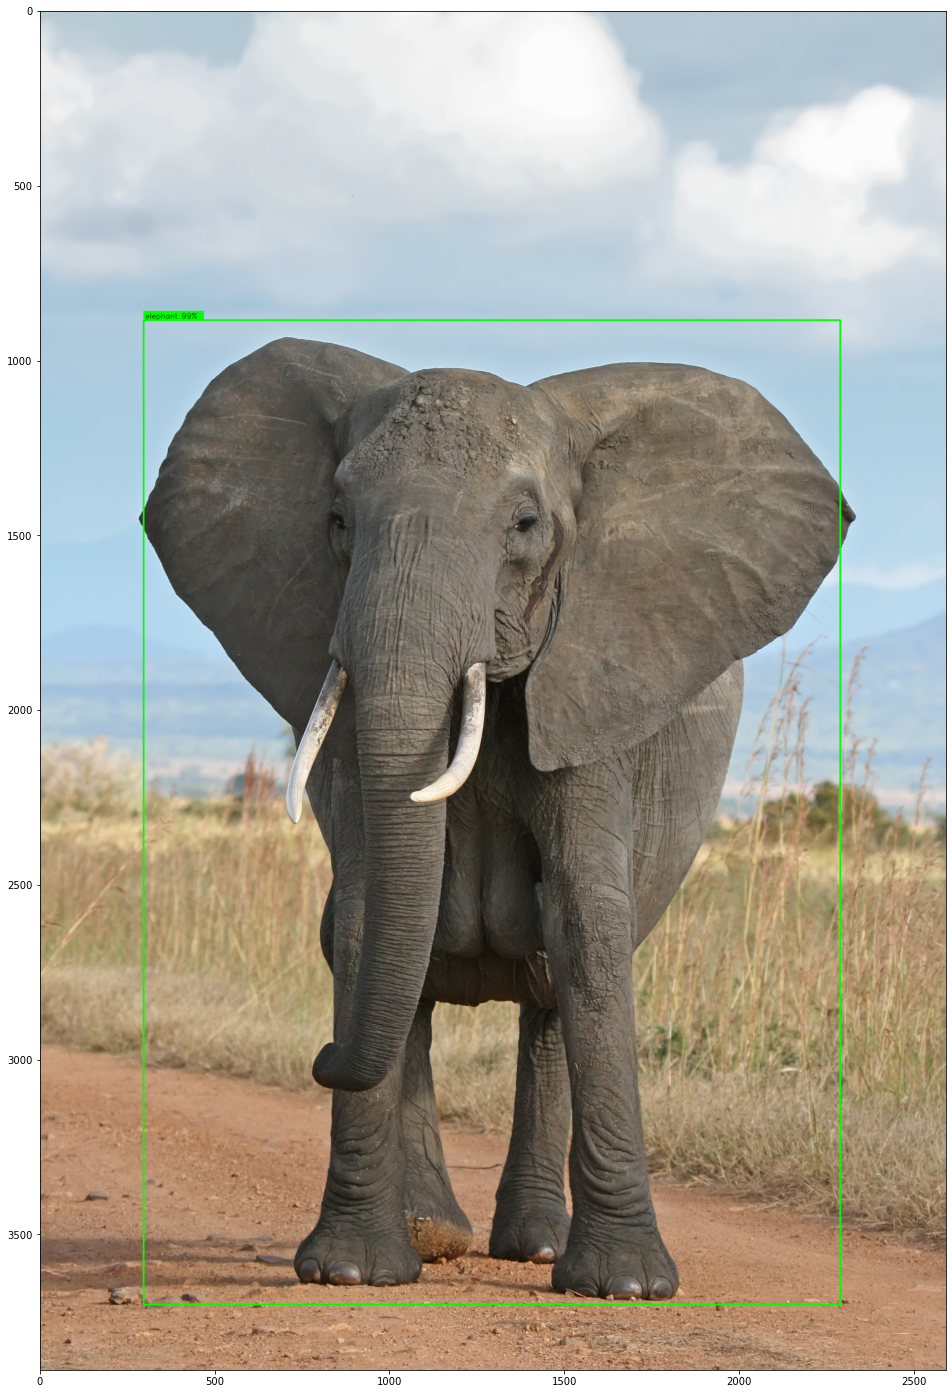

In [12]:
image_np = np.array(Image.open('data/elephant.jpg'))
detections = detect_objects_on_image(image_np, model)
image_with_detections = draw_detections_on_image(image_np, detections, labels)
plt.figure(figsize=(25, 25))
plt.imshow(image_with_detections)

In [13]:
def load_image_into_numpy_array(image):
  (im_width, im_height, _) = image.shape
  return np.array(image).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [24]:
def calculate_differencing(prev_f, f, vis=False):
    # Obliczanie różnicy między klatkami
    diff = cv2.absdiff(prev_f, f)
    if vis:
        plt.imshow(diff)
        plt.title('diff')
        plt.show()
        # cv2.imshow('diff', diff)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
    return diff

In [25]:
import matplotlib.pyplot as plt

def granulation(image, window_size=WINDOW_SIZE, vis=False):
    height, width, _ = image.shape
    width_add = 1 if width % WINDOW_SIZE != 0 else 0
    height_add = 1 if height % WINDOW_SIZE != 0 else 0
    granules = []
    for j in range(0, height, window_size):
        for i in range(0, width, window_size):
            granule = image[j, i, :]
            granules.append(granule)
    granules = np.array(granules).reshape(height // window_size+width_add, width // window_size+height_add, 3)
    if vis:
        fig, ax = plt.subplots(1, 2, figsize=(25, 10))
        fig.suptitle('Granulation')
        ax[0].imshow(image)
        ax[0].title.set_text('Original')
        ax[1].imshow(granules)
        ax[1].title.set_text('Granulated')
        plt.show()
    return granules

In [26]:
def compute_threshold(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = image_gray.shape
    width_add = 1 if width % WINDOW_SIZE != 0 else 0
    height_add = 1 if height % WINDOW_SIZE != 0 else 0
    granule_image = [[None for _ in range(width // WINDOW_SIZE+width_add)] for _ in range(height // WINDOW_SIZE+height_add)]

    for j in range(0, height, WINDOW_SIZE):
        for i in range(0, width, WINDOW_SIZE):
            granule = image_gray[j:min(j+WINDOW_SIZE, height), i:min(i+WINDOW_SIZE, width)]
            granule_image[j//WINDOW_SIZE][i//WINDOW_SIZE] = granule

    R_OT_best = 1
    R_BT_best = 1
    T_best = 0
    for T in range(30, 70, 5):
        O_T_lower = []
        O_T_upper = []
        B_T_lower = []
        B_T_upper = []
        for row in granule_image:
            for granule in row:
                granule_greater_T = granule > T
                granule_less_T = granule < T
                if len(granule_greater_T) > 1:
                    if np.all(granule_greater_T):
                        O_T_lower.append(granule)
                    if np.any(granule_greater_T):
                        O_T_upper.append(granule)
                if len(granule_less_T):
                    if np.all(granule_less_T):
                        B_T_lower.append(granule)
                    if np.any(granule_less_T):
                        B_T_upper.append(granule)
        R_OT = 1 - len(O_T_lower) / len(O_T_upper)
        R_BT = 1 - len(B_T_lower) / len(B_T_upper)
        if R_OT + R_BT < R_OT_best +  R_BT_best:
            R_OT_best = R_OT
            R_BT_best = R_BT
            T_best = T
        print('R_OT:', R_OT, '   R_BT:', R_BT, '   T:', T)
    return R_OT_best, R_BT_best, T_best

In [27]:
elephant = cv2.imread('data/elephant.jpg')
compute_threshold(elephant)


R_OT: 0.03731637971884383    R_BT: 0.9763513513513513    T: 30
R_OT: 0.05605886774538116    R_BT: 0.9563636363636363    T: 35
R_OT: 0.07173179924618134    R_BT: 0.9309600862998921    T: 40
R_OT: 0.09021090330282533    R_BT: 0.9164918170373478    T: 45
R_OT: 0.10729116754512058    R_BT: 0.8988218988218988    T: 50
R_OT: 0.12422783794624948    R_BT: 0.8859829562151044    T: 55
R_OT: 0.14296660751734147    R_BT: 0.8691612255148167    T: 60
R_OT: 0.16052887735236854    R_BT: 0.8550948389942655    T: 65


(0.07173179924618134, 0.9309600862998921, 40)

In [28]:
def upper_background_approximation(gf, frame, vis=False):    
    _, _, th = compute_threshold(frame)
    
    
    new_gf = np.zeros_like(gf)
    
    for i, row in enumerate(gf):
        for j, window in enumerate(row):
            if np.any(window < th):
                new_gf[i, j, :] = 255
    if vis:
        print("Threshold T:", th)
        plt.imshow(new_gf)
        plt.title('Upper background approximation')
        plt.show()
    return new_gf

In [34]:
def granulated_background_approximation(u_b, d, window_size=WINDOW_SIZE, vis=False):
    intersection = np.zeros_like(u_b)
    for i in range(0, d.shape[0], window_size):
        for j in range(0, d.shape[1], window_size):
            if np.all(d[i:min(i+window_size, d.shape[0]), j:min(j+window_size,d.shape[1]), :] > 0) and np.all(u_b[i//window_size, j//window_size, :] == 255):
                # print(i, j, np.max(d[i:i+window_size, j:j+window_size, :]))
                intersection[i//window_size, j//window_size, :] = 255
                
    BG = u_b - intersection
    
    if vis:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Background approximation')
        ax[0].imshow(u_b)
        ax[0].title.set_text('Upper background')
        ax[1].imshow(intersection)
        ax[1].title.set_text('Intersection')
        ax[2].imshow(BG)
        ax[2].title.set_text('Background')
        plt.show()
        
    return BG

In [30]:
def recognition_of_static_background_objects(img, model=model):

    # converted_img  = load_image_into_numpy_array(img)
    # result = model(converted_img)
    # print(result.keys())
    
    # return result
    image_np = np.array(img)
    detections = detect_objects_on_image(image_np, model)
    return detections

In [31]:
def visualise_static_objects(frame, detections, labels=labels):
    image_np = np.array(frame)
    image_with_detections = draw_detections_on_image(image_np, detections, labels)
    plt.figure(figsize=(25, 25))
    plt.imshow(image_with_detections)

In [32]:
def granulated_object_approximation(frame, BG, window_size=WINDOW_SIZE, vis=False):
    OB = np.zeros_like(frame)
    for i in range(0, frame.shape[0], window_size):
        for j in range(0, frame.shape[1], window_size):
            if np.all(BG[i//window_size, j//window_size, :] != 255):
                OB[i:i+window_size, j:j+window_size, :] = frame[i:i+window_size, j:j+window_size, :]
    if vis:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle('Object approximation')
        ax[0].imshow(frame)
        ax[0].title.set_text('Original')
        ax[1].imshow(OB)
        ax[1].title.set_text('Object')
        plt.show()
    return OB

Processing frame: 1


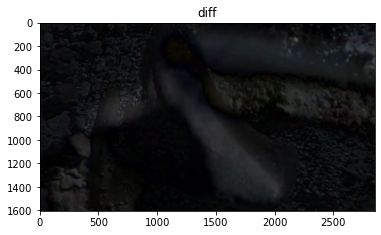

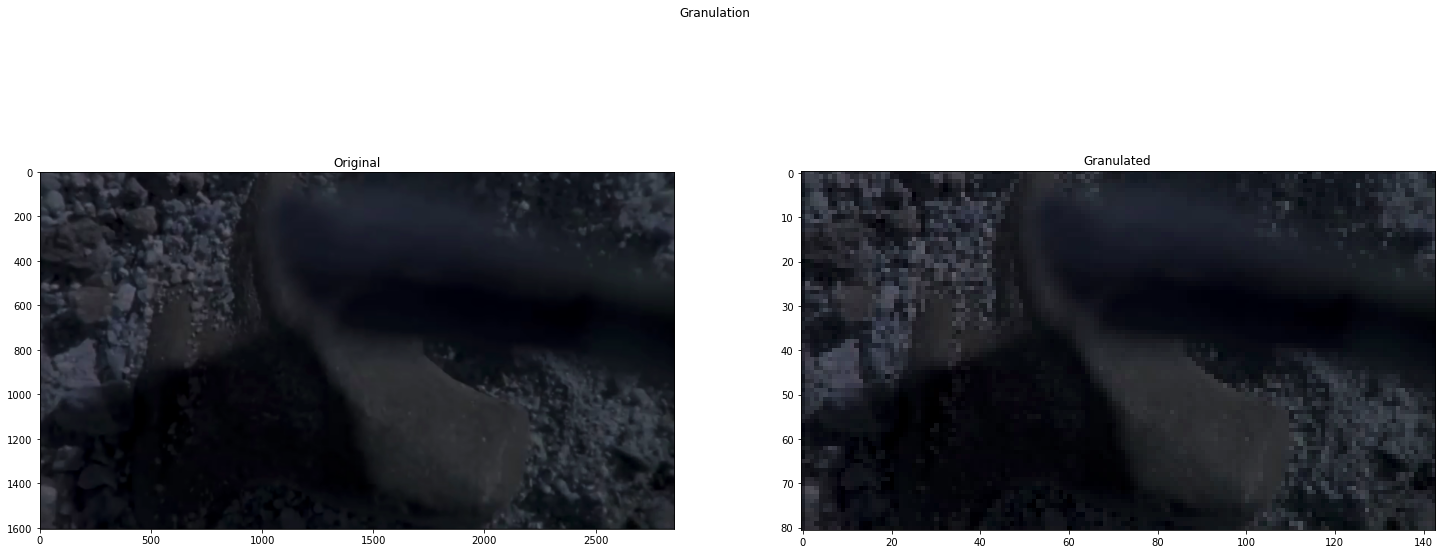

R_OT: 0.3762977160198051    R_BT: 0.3102253032928943    T: 30
R_OT: 0.48468229954614217    R_BT: 0.29389312977099236    T: 35
R_OT: 0.5871823204419889    R_BT: 0.2788923719958203    T: 40
R_OT: 0.7177312483434932    R_BT: 0.2577468867651318    T: 45
R_OT: 0.8706052917723813    R_BT: 0.22700762673844777    T: 50
R_OT: 0.8963195691202872    R_BT: 0.18446601941747576    T: 55
R_OT: 0.9253157605711148    R_BT: 0.15209025712786428    T: 60
R_OT: 0.9567131327953045    R_BT: 0.11695195064731945    T: 65
Threshold T: 30


Processing frame: 2


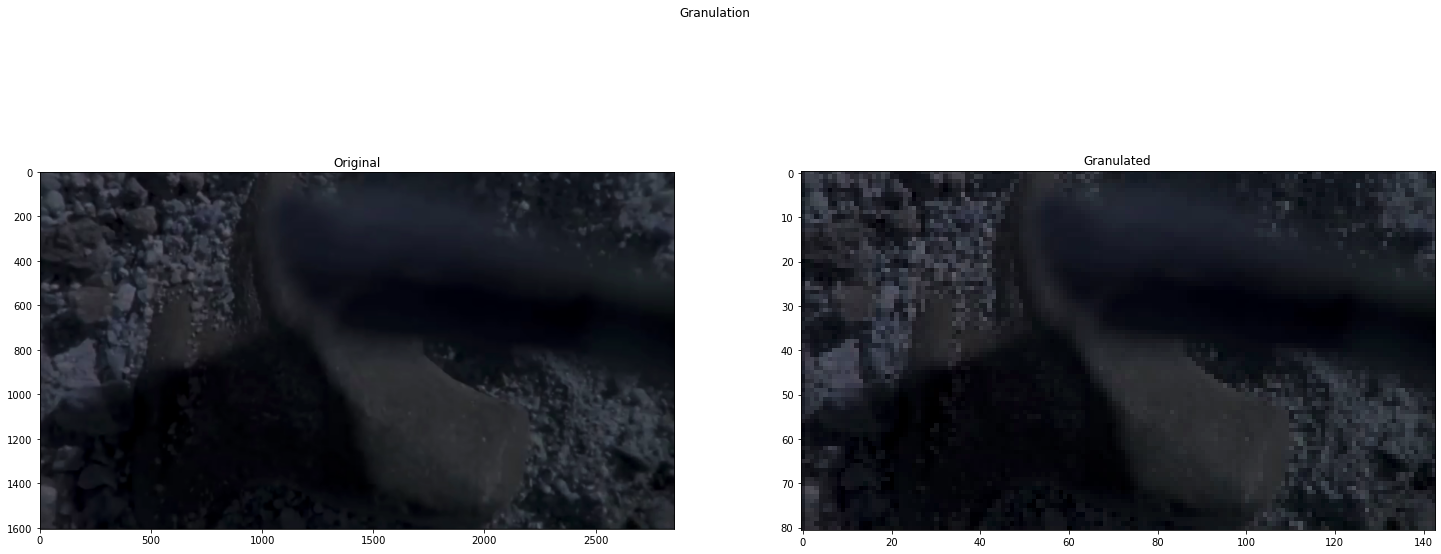

R_OT: 0.37376    R_BT: 0.30755876068376065    T: 30
R_OT: 0.4833459500378501    R_BT: 0.29165219404885956    T: 35
R_OT: 0.5854521335396861    R_BT: 0.2769987442444537    T: 40
R_OT: 0.7151579506238386    R_BT: 0.2566850082054253    T: 45
R_OT: 0.8698505286183011    R_BT: 0.22662838686524311    T: 50
R_OT: 0.8956560680698612    R_BT: 0.18411297440423657    T: 55
R_OT: 0.9254385964912281    R_BT: 0.1520027986706315    T: 60
R_OT: 0.9566176470588236    R_BT: 0.11686506212529324    T: 65
Threshold T: 30


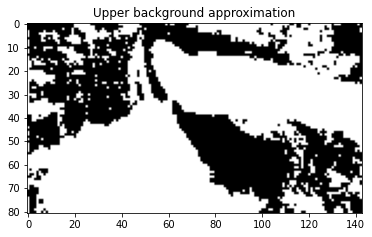

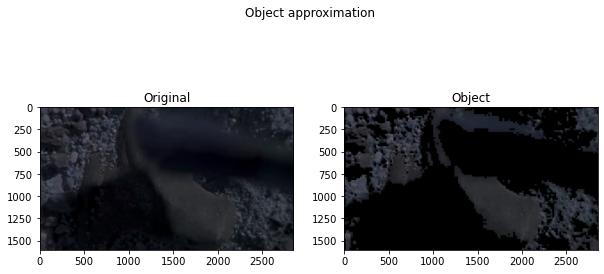

Processing frame: 3


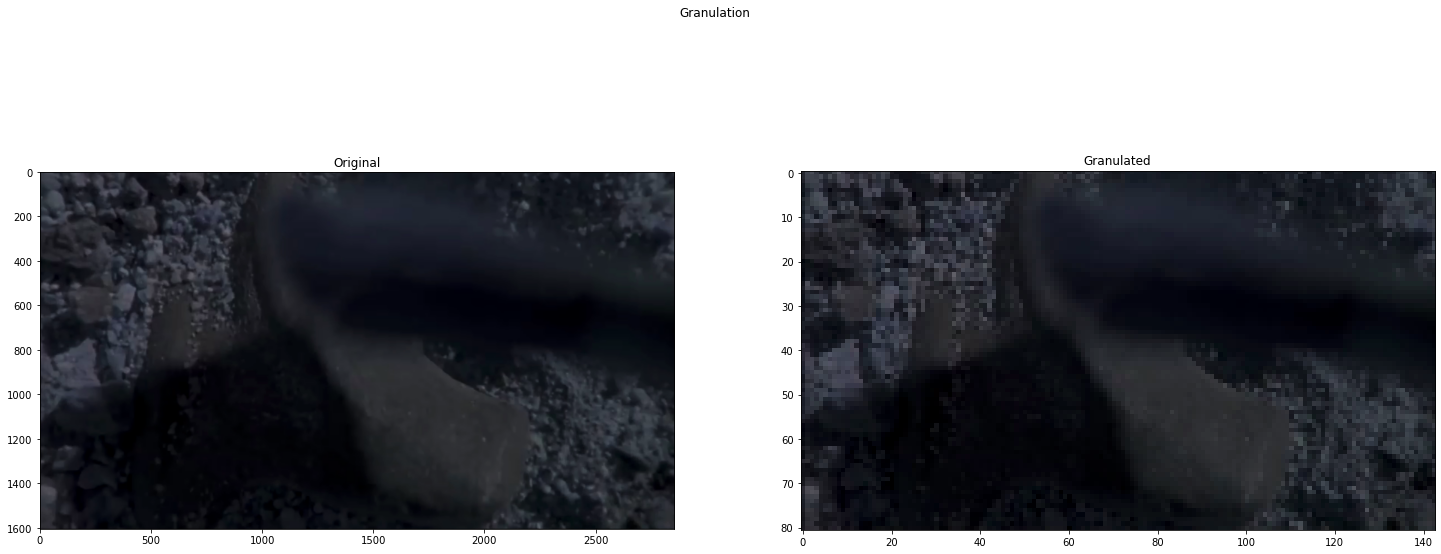

R_OT: 0.37859424920127793    R_BT: 0.3103769814839483    T: 30
R_OT: 0.48755186721991706    R_BT: 0.29627063849440016    T: 35
R_OT: 0.5895341134908368    R_BT: 0.2797451164734148    T: 40
R_OT: 0.7195025138925641    R_BT: 0.25850602409638557    T: 45
R_OT: 0.8719798052650559    R_BT: 0.22815359770321186    T: 50
R_OT: 0.896505376344086    R_BT: 0.18531591951994353    T: 55
R_OT: 0.9258241758241759    R_BT: 0.15237345921846313    T: 60
R_OT: 0.9574780058651027    R_BT: 0.11814785857006338    T: 65
Threshold T: 30


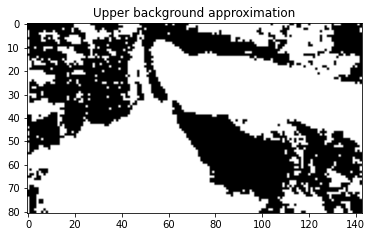

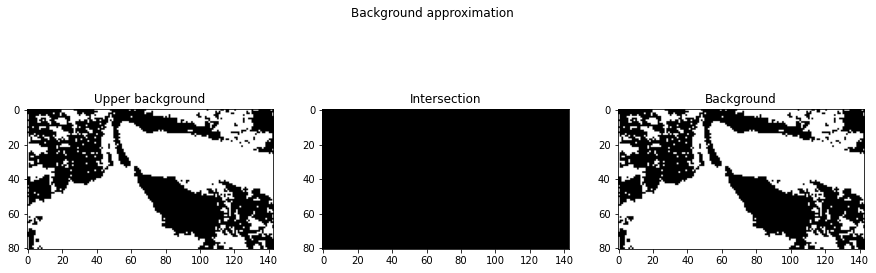

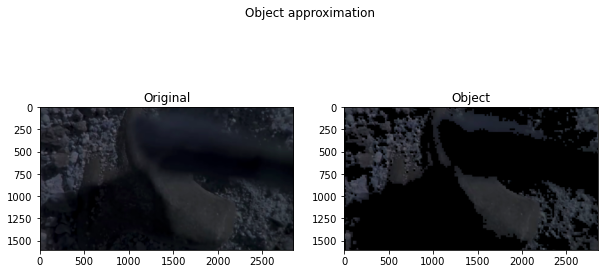

Processing frame: 4


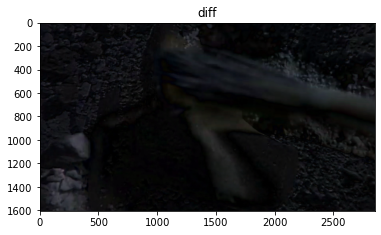

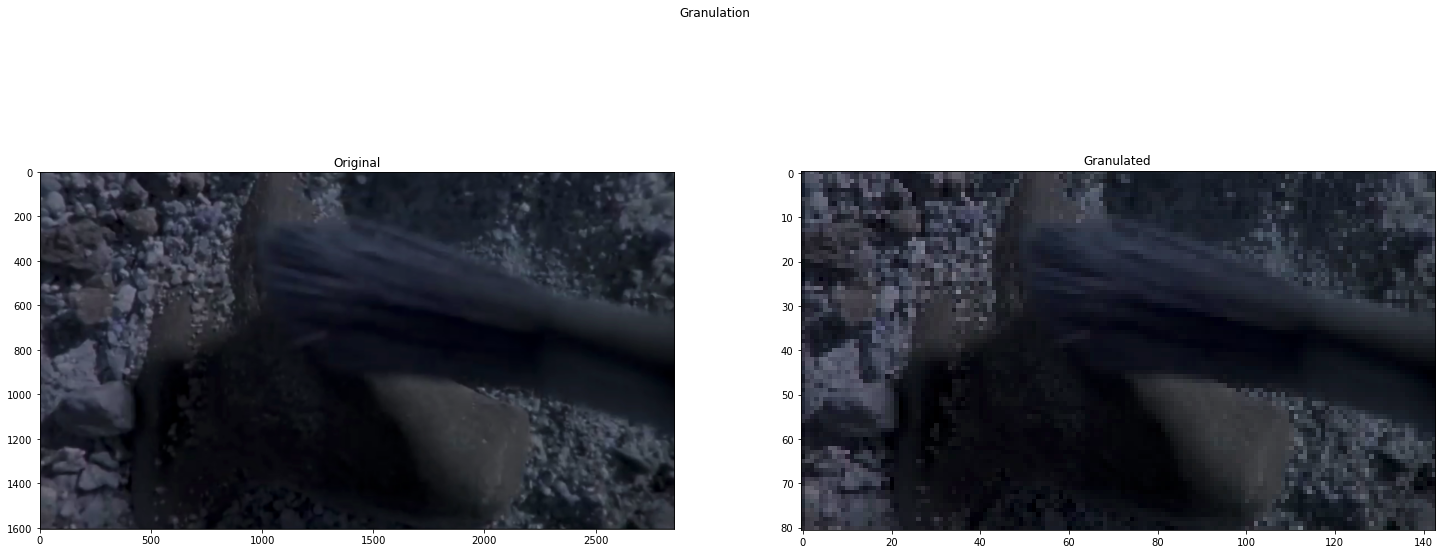

R_OT: 0.25800299686691186    R_BT: 0.3013100436681223    T: 30
R_OT: 0.35854092526690395    R_BT: 0.3276820059837584    T: 35
R_OT: 0.4288084965151012    R_BT: 0.3237139272271017    T: 40
R_OT: 0.5106738444403193    R_BT: 0.30570065864183515    T: 45
R_OT: 0.5983522142121525    R_BT: 0.30354131534569984    T: 50
R_OT: 0.6726447219069239    R_BT: 0.29569892473118276    T: 55
R_OT: 0.7737568341577714    R_BT: 0.282420478072652    T: 60
R_OT: 0.847832964251819    R_BT: 0.2474189458431444    T: 65
Threshold T: 30


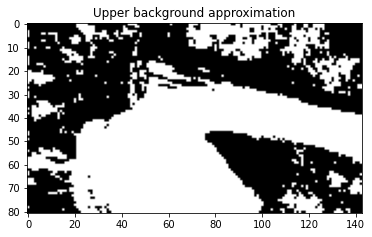

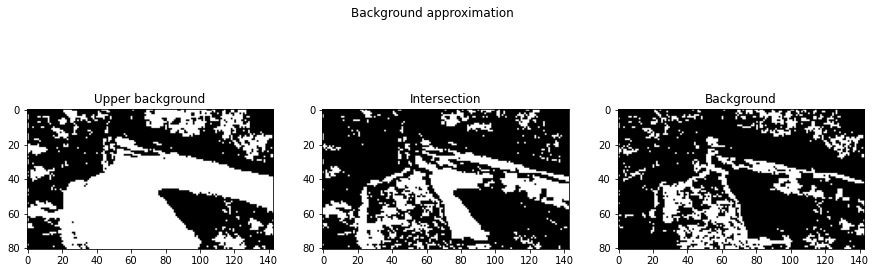

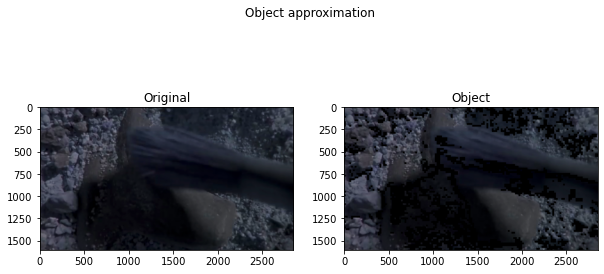

In [39]:
# Wczytanie filmu
cap = cv2.VideoCapture('data/video_jp_trim.mov')

# Przetwarzanie filmu klatka po klatce
first_frame = True
i: int = 1
while cap.isOpened():
    ret, frame = cap.read()
    if first_frame:
        first_frame = False
        prev_frame = frame
        continue
        
    if not ret:
        break

    print('Processing frame:', i)
    
    d = calculate_differencing(prev_frame, frame, vis=True)

    granulated_frame = granulation(frame, vis=True)

    UB = upper_background_approximation(granulated_frame, frame, vis=True)

    BG = granulated_background_approximation(UB, d, vis=True)

    # background_static_objects = recognition_of_static_background_objects(BG)

    # visualise_static_objects(frame, background_static_objects)

    # Obliczanie granulowanego modelu obiektu (OB)
    
    OB = granulated_object_approximation(frame, BG, vis=True)

    # Rozpoznawanie obiektów ruchomych
    prev_frame = frame
    i += 1
    if i == 5:
        break

# Zwolnienie zasobów
cap.release()
cv2.destroyAllWindows()